In [12]:
import gensim
import pandas as pd
import spacy
import numpy as np
from wefe.word_embedding_model import WordEmbeddingModel
from wefe.metrics import RIPA
from wefe.query import Query
import re
from gensim.models import KeyedVectors
import logging
import time
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
def cosine_similarity(v1: np.ndarray, v2: np.ndarray) -> float:
    return np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))

def compute_bias(adj, male_terms, female_terms, model):
    male_mean = np.mean([cosine_similarity(model[adj], model[m]) for m in male_terms if m in model])
    female_mean = np.mean([cosine_similarity(model[adj], model[f]) for f in female_terms if f in model])
    return male_mean - female_mean

def compute_individual_bias(
    adjectives,
    male_terms,
    female_terms,
    model,
    exclude_substrings=True
):
    """
    Computes, for each adjective, the 'bias' difference between the average 
    cosine similarity with male terms and the average cosine similarity 
    with female terms.

    Parameters
    ----------
    adjectives : list of str
        List of adjectives to be analyzed (already cleaned/lemmatized).
    male_terms : list of str
        Words representing 'masculinity' (e.g., ['man', 'boy', 'father', ...]).
    female_terms : list of str
        Words representing 'femininity' (e.g., ['woman', 'girl', 'lady', ...]).
    model : dict-like of {str -> np.ndarray} or a KeyedVectors-like object
        Your embedding model, where you can check `word in model` and 
        retrieve vectors using `model[word]`.
    exclude_substrings : bool, default=True
        Whether to exclude adjectives that contain any of the male or female 
        terms as substrings (e.g., "manlike" contains "man").

    Returns
    -------
    pd.DataFrame
        DataFrame with columns:
        ['word', 'male_mean', 'female_mean', 'bias_value'].
        Where 'bias_value' = male_mean - female_mean.
        Rows without sufficient embedding data are skipped.
    """

    if exclude_substrings:
        all_target_words = set(male_terms + female_terms)
        def has_target_substring(adj):
            return any(tw in adj for tw in all_target_words)
        adjectives = [adj for adj in adjectives if not has_target_substring(adj)]

    records = []

    # 2) Loop over each adjective
    for adj in adjectives:
        if adj not in model:
            continue

        adj_vec = model[adj]

        # Gather cosine similarities with male terms
        male_sims = []
        for m in male_terms:
            if m in model:
                male_sims.append(cosine_similarity(adj_vec, model[m]))

        # Gather cosine similarities with female terms
        female_sims = []
        for f in female_terms:
            if f in model:
                female_sims.append(cosine_similarity(adj_vec, model[f]))

        # Skip if we can't compute both male and female means
        if len(male_sims) == 0 or len(female_sims) == 0:
            continue

        # Compute means
        male_mean = np.mean(male_sims)
        female_mean = np.mean(female_sims)

        # Compute bias
        bias_value = male_mean - female_mean

        records.append({
            "word": adj,
            "male_mean": male_mean,
            "female_mean": female_mean,
            "bias_value": bias_value
        })

    df_bias = pd.DataFrame(records)
    return df_bias

# NIEUWE Functie: voeg een permutatietest toe voor statistische significantie
def compute_bias_with_pvalue(adj, male_terms, female_terms, model, permutations=1000, seed=42):
    np.random.seed(seed)

    # echte bias-score berekenen
    real_bias = compute_bias(adj, male_terms, female_terms, model)

    combined_terms = male_terms + female_terms
    num_male = len(male_terms)
    
    extreme_count = 0

    for _ in range(permutations):
        np.random.shuffle(combined_terms)
        permuted_male = combined_terms[:num_male]
        permuted_female = combined_terms[num_male:]

        # bereken bias-score onder permutatie
        permuted_bias = compute_bias(adj, permuted_male, permuted_female, model)

        # kijk of permuted bias extremer is dan echte bias
        if abs(permuted_bias) >= abs(real_bias):
            extreme_count += 1

    # Bereken de p-waarde:
    p_value = extreme_count / permutations

    return real_bias, p_value


In [44]:
# Load pre-trained Dutch FastText embeddings with Gensim
print("Loading word embeddings...")
nl_embeddings = gensim.models.KeyedVectors.load_word2vec_format("/Users/matthijstentije/University/MSc_Data-Science/Thesis/MSc_Data_Science_Thesis/data/cc.nl.300.vec.gz", binary=False)
print("Embeddings loaded.")

# Convert to WEFE-compatible format
fasttext_model = WordEmbeddingModel(nl_embeddings, "Dutch FastText")

2025-04-07 10:31:16,906 [INFO] loading projection weights from /Users/matthijstentije/University/MSc_Data-Science/Thesis/MSc_Data_Science_Thesis/data/cc.nl.300.vec.gz


Loading word embeddings...


2025-04-07 10:36:43,886 [INFO] KeyedVectors lifecycle event {'msg': 'loaded (2000000, 300) matrix of type float32 from /Users/matthijstentije/University/MSc_Data-Science/Thesis/MSc_Data_Science_Thesis/data/cc.nl.300.vec.gz', 'binary': False, 'encoding': 'utf8', 'datetime': '2025-04-07T10:36:43.885816', 'gensim': '4.3.3', 'python': '3.12.1 (v3.12.1:2305ca5144, Dec  7 2023, 17:23:38) [Clang 13.0.0 (clang-1300.0.29.30)]', 'platform': 'macOS-15.3.2-arm64-arm-64bit', 'event': 'load_word2vec_format'}


Embeddings loaded.


In [ ]:
# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s [%(levelname)s] %(message)s'
)

start_time = time.time()

logging.info("Loading Word2Vec model from file...")
model_path = "/Users/matthijstentije/University/MSc_Data-Science/Thesis/MSc_Data_Science_Thesis/data/sonar-320.txt"

try:
    model = KeyedVectors.load_word2vec_format(model_path, binary=False)
    logging.info("Model loaded successfully.")
except Exception as e:
    logging.error(f"Failed to load model: {e}")
    raise

elapsed_time = time.time() - start_time
logging.info(f"Model loading took {elapsed_time:.2f} seconds.")

# Check a word
word = "taal"
logging.info(f"Finding most similar words to: '{word}'")

try:
    similar_words = model.most_similar(word)
    logging.info("Similar words found:")
    for w, score in similar_words:
        print(f"{w}: {score:.4f}")
except KeyError:
    logging.warning(f"Word '{word}' not found in the vocabulary.")

2025-04-07 09:45:38,976 [INFO] Loading Word2Vec model from file...
2025-04-07 09:45:38,977 [INFO] loading projection weights from /Users/matthijstentije/University/MSc_Data-Science/Thesis/MSc_Data_Science_Thesis/data/sonar-320.txt
2025-04-07 09:47:16,550 [INFO] KeyedVectors lifecycle event {'msg': 'loaded (626711, 320) matrix of type float32 from /Users/matthijstentije/University/MSc_Data-Science/Thesis/MSc_Data_Science_Thesis/data/sonar-320.txt', 'binary': False, 'encoding': 'utf8', 'datetime': '2025-04-07T09:47:16.550052', 'gensim': '4.3.3', 'python': '3.12.1 (v3.12.1:2305ca5144, Dec  7 2023, 17:23:38) [Clang 13.0.0 (clang-1300.0.29.30)]', 'platform': 'macOS-15.3.2-arm64-arm-64bit', 'event': 'load_word2vec_format'}
2025-04-07 09:47:16,560 [INFO] Model loaded successfully.
2025-04-07 09:47:16,564 [INFO] Model loading took 97.59 seconds.
2025-04-07 09:47:16,565 [INFO] Finding most similar words to: 'taal'
2025-04-07 09:47:17,743 [INFO] Similar words found:


moedertaal: 0.7225
talen: 0.6961
ladino: 0.6668
nederlands: 0.6628
landstaal: 0.6611
engels: 0.6596
kiswahili: 0.6552
papiaments: 0.6535
berbertaal: 0.6488
papiamento: 0.6475


In [8]:
# Load spaCy Dutch model
nlp = spacy.load('nl_core_news_lg')

def extract_adjectives_from_csv(file_path):
    """
    Leest een CSV-bestand in, parse elke phrase, en retourneert unieke gelemmatiseerde bijvoeglijke naamwoorden.
    """
    logging.info(f"Loading CSV file: {file_path}")
    try:
        df = pd.read_csv(file_path, delimiter=';', usecols=[0], names=["Group"], header=0)
        logging.info(f"CSV loaded successfully with shape: {df.shape}")
    except Exception as e:
        logging.error(f"Failed to load CSV file: {e}")
        raise

    df.dropna(subset=["Group"], inplace=True)
    logging.info(f"Dropped NaN rows. Remaining phrases: {len(df)}")

    adjectives = []

    logging.info("Starting POS tagging and lemmatization...")
    for idx, phrase in enumerate(df["Group"]):
        doc = nlp(phrase)
        for token in doc:
            if token.pos_ == "ADJ" and token.is_alpha:
                adjectives.append(token.lemma_.lower())
        if idx % 1000 == 0 and idx > 0:
            logging.info(f"Processed {idx} phrases...")

    unique_adjectives = list(dict.fromkeys(adjectives))
    logging.info(f"Extracted {len(unique_adjectives)} unique adjectives.")
    return unique_adjectives

# ---- Use the function ----
csv_file_path = "/Users/matthijstentije/University/MSc_Data-Science/Thesis/MSc_Data_Science_Thesis/data/Corpus_Hedendaags_Nederlands_Adjectives.csv"
result_adjectives = extract_adjectives_from_csv(csv_file_path)

# Log basic stats
print(f"\n Total unique lemmas: {len(result_adjectives)}")

# Words missing from Word2Vec model
missing_words = [word for word in result_adjectives if word not in model]
print(f" Total missing words from embedding model: {len(missing_words)}")
print("Sample missing words:", missing_words[:10])

# Words that exist in the model
filtered_lemmas = [word for word in result_adjectives if word in model]

# Exclude adjectives containing target words
target_words = [
    "man", "kerel", "jongen", "vader", "zoon", "vent", "gast", "meneer", "opa", "oom",
    "vrouw", "dame", "meisje", "moeder", "dochter", "tante", "oma", "mevrouw", "meid",
]

filtered_adjectives = [
    adj for adj in filtered_lemmas
    if not any(target_word in adj for target_word in target_words)
]

print(f"Remaining adjectives after filtering: {len(filtered_adjectives)}")


2025-04-07 09:52:06,433 [INFO] Loading CSV file: /Users/matthijstentije/University/MSc_Data-Science/Thesis/MSc_Data_Science_Thesis/data/Corpus_Hedendaags_Nederlands_Adjectives.csv
2025-04-07 09:52:06,453 [INFO] CSV loaded successfully with shape: (19242, 1)
2025-04-07 09:52:06,463 [INFO] Dropped NaN rows. Remaining phrases: 19239
2025-04-07 09:52:06,464 [INFO] Starting POS tagging and lemmatization...
2025-04-07 09:52:09,651 [INFO] Processed 1000 phrases...
2025-04-07 09:52:12,766 [INFO] Processed 2000 phrases...
2025-04-07 09:52:15,956 [INFO] Processed 3000 phrases...
2025-04-07 09:52:18,848 [INFO] Processed 4000 phrases...
2025-04-07 09:52:21,834 [INFO] Processed 5000 phrases...
2025-04-07 09:52:24,879 [INFO] Processed 6000 phrases...
2025-04-07 09:52:27,998 [INFO] Processed 7000 phrases...
2025-04-07 09:52:31,075 [INFO] Processed 8000 phrases...
2025-04-07 09:52:34,417 [INFO] Processed 9000 phrases...
2025-04-07 09:52:37,728 [INFO] Processed 10000 phrases...
2025-04-07 09:52:40,841 


📌 Total unique lemmas: 2938
❌ Total missing words from embedding model: 161
Sample missing words: ['polygaum', 'wereldwijaz', 'grooot', 'ongerussen', 'mannek', 'alleenstaan', 'slapap', 'kieen', 'querulante', 'milieubewu']
✅ Remaining adjectives after filtering: 2753


In [9]:
MALE_WORDS = [
     "man", "kerel", "jongen", "vader", "zoon", "vent", "gast", "meneer", "opa", "oom",
]
FEMALE_WORDS = [
    "vrouw", "dame", "meisje", "moeder", "dochter", "tante", "oma", "mevrouw", "meid",
]

In [11]:
logging.info("Starting bias computation for filtered adjectives...")

results = []
skipped = []

for i, adj in enumerate(filtered_adjectives):
    if adj in model:
        try:
            bias, pval = compute_bias_with_pvalue(adj, MALE_WORDS, FEMALE_WORDS, model)
            results.append({'word': adj, 'bias': bias, 'p_value': pval})
        except Exception as e:
            logging.warning(f"Error processing '{adj}': {e}")
            skipped.append(adj)
    else:
        skipped.append(adj)

logging.info(f"Finished computing bias for {len(results)} adjectives.")
logging.info(f"Skipped {len(skipped)} words (not in model or error during computation).")

# Convert results to DataFrame
df_bias_pval = pd.DataFrame(results)

# Sort by p-value
df_bias_pval_sorted = df_bias_pval.sort_values(by='p_value', ascending=True)

# Show top entries
print(df_bias_pval_sorted.head(10))

2025-04-07 09:53:59,026 [INFO] Starting bias computation for filtered adjectives...
2025-04-07 09:59:01,339 [INFO] Finished computing bias for 2753 adjectives.
2025-04-07 09:59:01,340 [INFO] Skipped 0 words (not in model or error during computation).


                 word      bias  p_value
1543            knapp -0.057418    0.001
1291        statutair  0.046310    0.002
1962          indisch -0.042601    0.003
1194  maatschappelijk -0.042173    0.003
928             lamme  0.040604    0.006
1473           luther  0.058629    0.006
79       alleenstaand -0.047796    0.006
731          lesbisch -0.081243    0.006
1439            zedig -0.046326    0.007
170           corrupt  0.062605    0.008


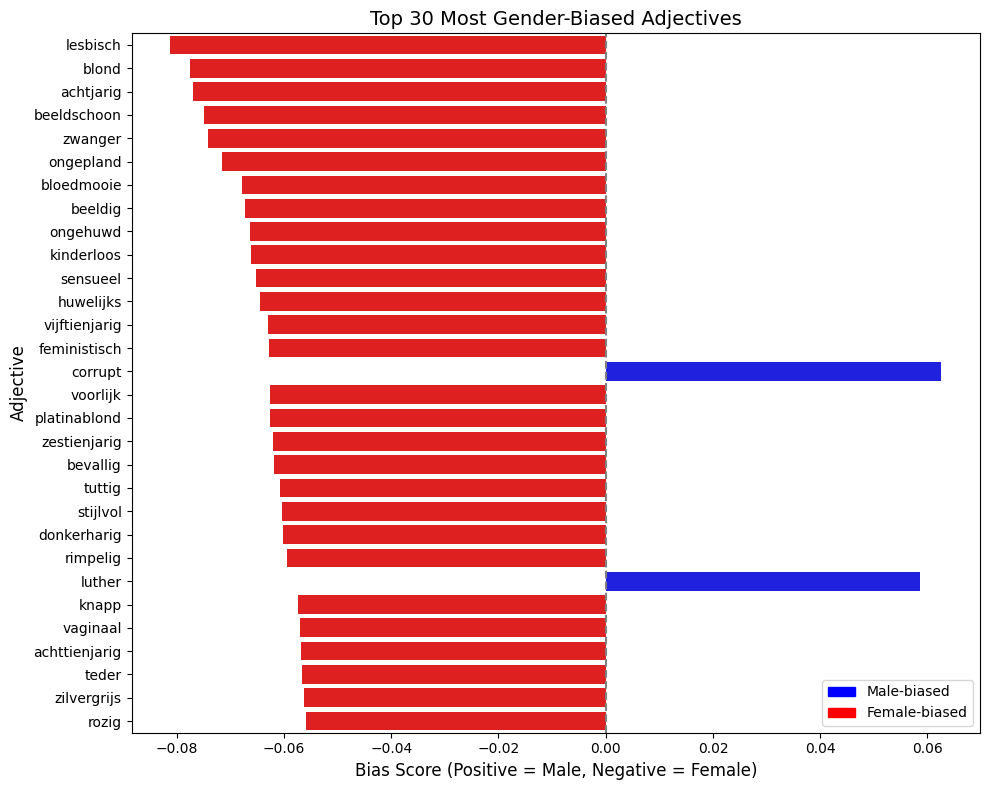

In [13]:
#  'df_bias_pval' containing:
# columns: ['word', 'bias', 'p_value']

# First, get the top 30 adjectives based on absolute bias
df_bias_pval['abs_bias'] = df_bias_pval['bias'].abs()
top30_bias = df_bias_pval.sort_values(by='abs_bias', ascending=False).head(30)

# Add a column to specify gender-bias direction (for coloring)
top30_bias['gender'] = top30_bias['bias'].apply(lambda x: 'male' if x > 0 else 'female')

# Define colors: blue for male, red for female
palette = {'male': 'blue', 'female': 'red'}

# Plotting
plt.figure(figsize=(10, 8))
sns.barplot(
    x='bias',
    y='word',
    data=top30_bias,
    hue='gender',
    palette=palette,
    dodge=False
)

plt.title('Top 30 Most Gender-Biased Adjectives', fontsize=14)
plt.xlabel('Bias Score (Positive = Male, Negative = Female)', fontsize=12)
plt.ylabel('Adjective', fontsize=12)
plt.axvline(0, color='grey', linestyle='--')

# Adding legend manually
from matplotlib.patches import Patch
legend_handles = [Patch(color='blue', label='Male-biased'),
                  Patch(color='red', label='Female-biased')]
plt.legend(handles=legend_handles, loc='lower right')

plt.tight_layout()
plt.show()

In [14]:
def compute_individual_bias(
    adjectives,
    male_terms,
    female_terms,
    model,
    exclude_substrings=True
):
    """
    Berekent voor elk bijvoeglijk naamwoord (ADJ) het 'bias'-verschil 
    tussen gemiddelde cosinesim. met mannelijke termen en 
    gemiddelde cosinesim. met vrouwelijke termen.

    Parameters
    ----------
    adjectives : list of str
        De lijst van te analyseren bijvoeglijke naamwoorden (al schoongemaakt/gelmmatized).
    male_terms : list of str
        Woorden die 'mannelijkheid' representeren (bijv. ['man','jongen','vader',...]).
    female_terms : list of str
        Woorden die 'vrouwelijkheid' representeren (bijv. ['vrouw','meisje','dame',...]).
    model : dict-like of {str -> np.ndarray} of a KeyedVectors-like object
        Jouw embeddingmodel, waarbij je `word in model` kunt checken en `model[word]`
        de vector geeft.
    exclude_substrings : bool, default=True
        Of we woorden moeten overslaan die 'male_terms' of 'female_terms' 
        als substring bevatten (bijv. "mannenachtig" bevat "man").

    Returns
    -------
    pd.DataFrame
        DataFrame met kolommen:
        ['word', 'male_mean', 'female_mean', 'bias_value'].
        Waar 'bias_value' = male_mean - female_mean.
        Rijen waar niet genoeg info (embeddings) beschikbaar was, worden overgeslagen.
    """

    # 1) Optioneel substring-filter:
    if exclude_substrings:
        all_target_words = set(male_terms + female_terms)
        def has_target_substring(adj):
            return any(tw in adj for tw in all_target_words)
        adjectives = [adj for adj in adjectives if not has_target_substring(adj)]

    records = []

    # 2) Loop over elke adjective
    for adj in adjectives:
        # Check of het adj in het model zit
        if adj not in model:
            continue

        adj_vec = model[adj]

        # Verzamel cosines met mannelijke termen
        male_sims = []
        for m in male_terms:
            if m in model:
                male_sims.append(cosine_similarity(adj_vec, model[m]))

        # Verzamel cosines met vrouwelijke termen
        female_sims = []
        for f in female_terms:
            if f in model:
                female_sims.append(cosine_similarity(adj_vec, model[f]))

        # Check of we beide lijsten niet leeg zijn
        if len(male_sims) == 0 or len(female_sims) == 0:
            # Dan kunnen we geen bias berekenen
            continue

        # Gemiddelde cosines
        male_mean = np.mean(male_sims)
        female_mean = np.mean(female_sims)

        # Bias = verschil man - vrouw
        bias_value = male_mean - female_mean

        records.append({
            "word": adj,
            "male_mean": male_mean,
            "female_mean": female_mean,
            "bias_value": bias_value
        })

    # Omzetten naar DataFrame
    df_bias = pd.DataFrame(records)

    return df_bias

individual_bias = compute_individual_bias(adjectives=filtered_adjectives, male_terms=MALE_WORDS, female_terms=FEMALE_WORDS, model=model)
print(f"Totaal aantal berekende bias-waarden: {len(individual_bias)}")
    
    # Sorteer oplopend op 'bias_value'
df_sorted = individual_bias.sort_values("bias_value", ascending=True)

    # Selecteer de 30 laagste scores
lowest_30 = df_sorted.head(30)

    # Selecteer de 30 hoogste scores
highest_30 = df_sorted.tail(30)

print("=== 30 Laagste Scores (bias_value) ===")
for _, row in lowest_30.iterrows():
    print(f"{row['word']}: {row['bias_value']:.4f} "
            f"(male_mean={row['male_mean']:.4f}, female_mean={row['female_mean']:.4f})")

print("\n=== 30 Hoogste Scores (bias_value) ===")
for _, row in highest_30.iloc[::-1].iterrows():
    print(f"{row['word']}: {row['bias_value']:.4f} "
        f"(male_mean={row['male_mean']:.4f}, female_mean={row['female_mean']:.4f})")
    
df_sorted_male = individual_bias.sort_values("male_mean", ascending=False)
top_30_male_mean = df_sorted_male.head(30)

print("\n=== 30 Hoogste male_mean (onafhankelijk van female_mean) ===")
for _, row in top_30_male_mean.iterrows():
    print(f"{row['word']} - male_mean={row['male_mean']:.4f}, "
          f"female_mean={row['female_mean']:.4f}, bias={row['bias_value']:.4f}")

# En idem voor female_mean
df_sorted_female = individual_bias.sort_values("female_mean", ascending=False)
top_30_female_mean = df_sorted_female.head(30)

print("\n=== 30 Hoogste female_mean (onafhankelijk van male_mean) ===")
for _, row in top_30_female_mean.iterrows():
    print(f"{row['word']} - female_mean={row['female_mean']:.4f}, "
          f"male_mean={row['male_mean']:.4f}, bias={row['bias_value']:.4f}")

Totaal aantal berekende bias-waarden: 2753
=== 30 Laagste Scores (bias_value) ===
lesbisch: -0.0812 (male_mean=0.3926, female_mean=0.4738)
blond: -0.0776 (male_mean=0.3504, female_mean=0.4280)
achtjarig: -0.0769 (male_mean=0.3788, female_mean=0.4558)
beeldschoon: -0.0749 (male_mean=0.3908, female_mean=0.4657)
zwanger: -0.0741 (male_mean=0.4026, female_mean=0.4768)
ongepland: -0.0716 (male_mean=0.2737, female_mean=0.3454)
bloedmooie: -0.0678 (male_mean=0.4200, female_mean=0.4879)
beeldig: -0.0673 (male_mean=0.3034, female_mean=0.3707)
ongehuwd: -0.0663 (male_mean=0.2719, female_mean=0.3382)
kinderloos: -0.0661 (male_mean=0.3426, female_mean=0.4087)
sensueel: -0.0653 (male_mean=0.2770, female_mean=0.3423)
huwelijks: -0.0644 (male_mean=0.1827, female_mean=0.2471)
vijftienjarig: -0.0630 (male_mean=0.2719, female_mean=0.3349)
feministisch: -0.0628 (male_mean=0.2635, female_mean=0.3262)
voorlijk: -0.0625 (male_mean=0.3400, female_mean=0.4025)
platinablond: -0.0625 (male_mean=0.3645, female_m

In [15]:
individual_bias_dict = individual_bias.set_index("word")["bias_value"].to_dict()
search_words = ["sterk", "zacht", "moedig", "emotioneel", "dominant", 
                "zorgzaam", "aardig", "knap", "schattig"]

print("Bias scores voor specifieke woorden:")
for word in search_words:
    # Let op: als je bij de filtering alles lowercase hebt gemaakt, doe je hier ook word.lower()
    w_lower = word.lower()
    bias_value = individual_bias_dict.get(w_lower)

    if bias_value is not None:
        print(f"{word}: {bias_value:.3f}")
    else:
        print(f"{word}: Niet gevonden in df_bias (of model).")

Bias scores voor specifieke woorden:
sterk: 0.014
zacht: -0.037
moedig: -0.022
emotioneel: -0.033
dominant: 0.019
zorgzaam: -0.028
aardig: 0.002
knap: -0.009
schattig: -0.035


## RIPA

In [41]:
from wefe.word_embedding_model import WordEmbeddingModel

class GensimDutchEmbeddingModel(WordEmbeddingModel):
    def __init__(self, keyed_vectors):
        super().__init__(wv=keyed_vectors)
w2v_model = GensimDutchEmbeddingModel(model)

# Step 5: Test with a word
word = "taal"
logging.info(f"Finding most similar words to: '{word}'")

try:
    similar_words = model.most_similar(word)
    logging.info("Similar words found:")
    for w, score in similar_words:
        print(f"{w}: {score:.4f}")
except KeyError:
    logging.warning(f"Word '{word}' not found in the vocabulary.")

2025-04-07 10:29:30,684 [INFO] Finding most similar words to: 'taal'


2025-04-07 10:29:30,734 [INFO] Similar words found:


moedertaal: 0.7225
talen: 0.6961
ladino: 0.6668
nederlands: 0.6628
landstaal: 0.6611
engels: 0.6596
kiswahili: 0.6552
papiaments: 0.6535
berbertaal: 0.6488
papiamento: 0.6475


In [ ]:
print(f"Number of adjectives (filtered_lemmas): {len(filtered_adjectives)}")

# Define the query
query = Query(
    target_sets=[
        ["man", "kerel", "jongen", "vader", "zoon", "vent", "meneer", "opa", "oom"],
        ["vrouw", "dame", "meisje", "moeder", "dochter", "tante", "oma", "mevrouw", "meid"]],
    attribute_sets=[filtered_adjectives],  # Ensure it's a list of lists
    target_sets_names=["Male Terms", "Female Terms"],
    attribute_sets_names=["Adjectives"],
)

ripa = RIPA()
result = ripa.run_query(query, w2v_model)


Number of adjectives (filtered_lemmas): 2753


In [28]:
# 'result["word_values"]' {woord: {'mean': x, 'std': y}, ...}
df_ripa = pd.DataFrame({
    'Word': result["word_values"].keys(),
    'Mean Score': [val['mean'] for val in result["word_values"].values()],
    'Std Dev': [val['std'] for val in result["word_values"].values()],
})

# Sorteer op Mean Score (die RIPA per woord toekent) en bekijk
df_ripa = df_ripa.sort_values(by="Mean Score", ascending=False).reset_index(drop=True)
for word in search_words:
    if word in result["word_values"]:
        mean_val = result["word_values"][word]["mean"]
        std_val = result["word_values"][word]["std"]
        print(f"{word}: Mean={mean_val:.3f}, Std={std_val:.3f}")
    else:
        print(f"{word}: niet gevonden in RIPA-result.")

sterk: Mean=0.019, Std=0.029
zacht: Mean=-0.057, Std=0.078
moedig: Mean=-0.031, Std=0.052
emotioneel: Mean=-0.046, Std=0.064
dominant: Mean=0.007, Std=0.051
zorgzaam: Mean=-0.043, Std=0.072
aardig: Mean=-0.007, Std=0.074
knap: Mean=-0.024, Std=0.095
schattig: Mean=-0.059, Std=0.097


In [29]:
# 1) Voeg een Z-score-kolom toe:
mean_of_scores = df_ripa["Mean Score"].mean()
std_of_scores = df_ripa["Mean Score"].std()

df_ripa["Z-Score"] = (df_ripa["Mean Score"] - mean_of_scores) / std_of_scores

# 2) Als je daarna wilt sorteren op Z-Score (hoog -> laag), doe je:
df_ripa = df_ripa.sort_values("Z-Score", ascending=False).reset_index(drop=True)

# 3) Print de eerste rijen om te zien hoe de Z-scores eruitzien:
print(df_ripa.head(10))
print(df_ripa.tail(10))

               Word  Mean Score   Std Dev   Z-Score
0            luther    0.093703  0.054713  3.776857
1           corrupt    0.077202  0.069673  3.176023
2              dood    0.070344  0.080848  2.926319
3   onoverwinnelijk    0.069247  0.061142  2.886385
4         goddeloos    0.068410  0.077281  2.855910
5        impopulair    0.065271  0.067593  2.741602
6       gewetenloos    0.063345  0.091916  2.671476
7  plaatsvervangend    0.062924  0.059071  2.656163
8       incompetent    0.062248  0.075782  2.631555
9         steenrijk    0.061982  0.068094  2.621870
              Word  Mean Score   Std Dev   Z-Score
2743      stijlvol   -0.097000  0.074878 -3.166799
2744  platinablond   -0.097472  0.123362 -3.183998
2745       beeldig   -0.098894  0.086156 -3.235759
2746    bloedmooie   -0.099148  0.087792 -3.245038
2747     ongepland   -0.103742  0.123087 -3.412308
2748     achtjarig   -0.104324  0.122664 -3.433492
2749   beeldschoon   -0.107545  0.117354 -3.550768
2750         blond  

In [64]:
df_combined = pd.merge(
    df_bias_pval,
    df_ripa[['Word', 'Mean Score']],
    left_on='word',
    right_on='Word',
    how='inner'
).rename(columns={'Mean Score': 'RIPA_score'})
df_combined['cosine_bias_z'] = (df_combined['bias'] - df_combined['bias'].mean()) / df_combined['bias'].std()
df_combined['ripa_z'] = (df_combined['RIPA_score'] - df_combined['RIPA_score'].mean()) / df_combined['RIPA_score'].std()
# verwijder overtollige kolom
df_combined.drop('Word', axis=1, inplace=True)

# voorbeeld inspectie
print(df_combined.head())

         word      bias  p_value  abs_bias  RIPA_score  cosine_bias_z  \
0       groot  0.012608    0.631  0.012608    0.019918       0.741863   
1      vreemd  0.015225    0.513  0.015225    0.010203       0.873263   
2    prachtig -0.026836    0.243  0.026836   -0.048913      -1.239154   
3  onschuldig  0.011254    0.617  0.011254    0.010799       0.673814   
4     angstig -0.004337    0.883  0.004337   -0.010091      -0.109181   

     ripa_z  
0  1.090263  
1  0.736532  
2 -1.415915  
3  0.758234  
4 -0.002398  


Correlation between Cosine Similarity Bias and RIPA: r = 0.962, p = 0.0000


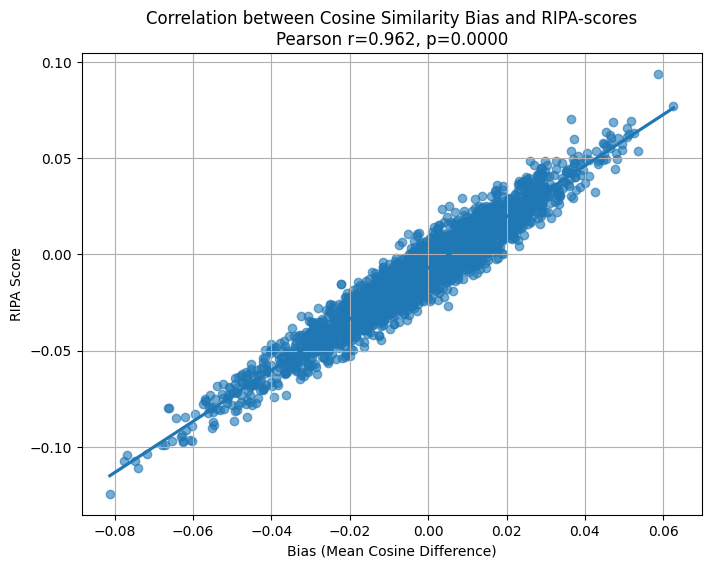

In [65]:
import scipy.stats as stats


# Bereken Pearson correlatie
corr, p_corr = stats.pearsonr(df_combined['bias'], df_combined['RIPA_score'])
print(f"Correlation between Cosine Similarity Bias and RIPA: r = {corr:.3f}, p = {p_corr:.4f}")

# Scatterplot ter visualisatie:
plt.figure(figsize=(8, 6))
sns.regplot(x='bias', y='RIPA_score', data=df_combined, scatter_kws={'alpha':0.6})
plt.title(f"Correlation between Cosine Similarity Bias and RIPA-scores\nPearson r={corr:.3f}, p={p_corr:.4f}")
plt.xlabel("Bias (Mean Cosine Difference)")
plt.ylabel("RIPA Score")
plt.grid(True)
plt.show()


In [66]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Add model name
df_combined_w2v['Model'] = 'Word2Vec'
df_combined_ft['Model']  = 'FastText'

# Combine into one
df_len_compare = pd.concat([df_combined_w2v, df_combined_ft], ignore_index=True)

# Add adjective length
df_len_compare['adjective_length'] = df_len_compare['word'].str.len()

# --- Set up figure ---
plt.figure(figsize=(14, 7))

# Scatterplot by model
sns.scatterplot(
    data=df_len_compare,
    x='adjective_length',
    y='ripa_z',
    hue='Model',
    palette={'Word2Vec': '#1f77b4', 'FastText': '#ff7f0e'},
    alpha=0.6,
    s=50,
    edgecolor='black'
)

# Regression lines per model
for model, color in [('Word2Vec', '#1f77b4'), ('FastText', '#ff7f0e')]:
    subset = df_len_compare[df_len_compare['Model'] == model]
    sns.regplot(
        data=subset,
        x='adjective_length',
        y='ripa_z',
        scatter=False,
        color=color,
        label=f'{model} Trend'
    )

# Reference line at y=0
plt.axhline(0, color='black', linestyle='--', linewidth=0.8)

# Annotate strongest outliers
top_outliers = df_len_compare[df_len_compare['ripa_z'].abs() > 4.5]
for _, row in top_outliers.iterrows():
    plt.text(
        row['adjective_length'] + 0.2,
        row['ripa_z'],
        row['word'],
        fontsize=9,
        alpha=0.8
    )

# Labels & aesthetics
plt.xlabel("Adjective Length (in characters)", fontsize=12)
plt.ylabel("RIPA Z-score", fontsize=12)
plt.title("RIPA Z-score vs. Adjective Length\nCompared Across Word2Vec and FastText", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(title="Embedding Model")
plt.tight_layout()
plt.show()


NameError: name 'df_combined_w2v' is not defined

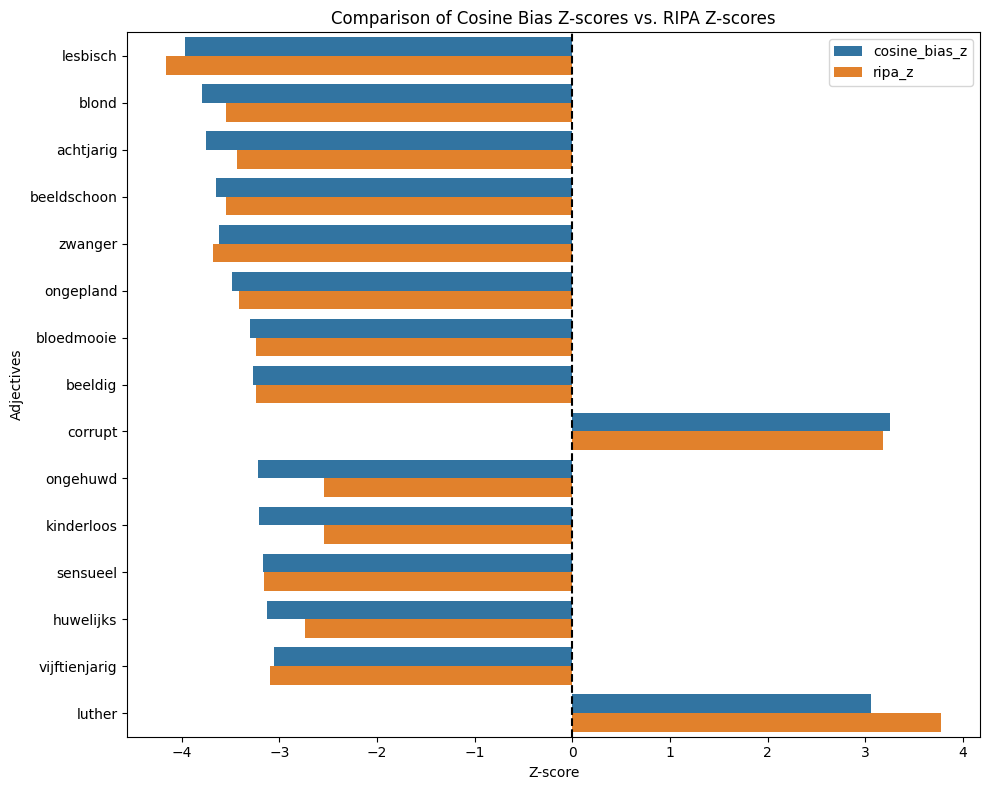

In [ ]:
# 1) Pick the top 15 based on the absolute cosine z-score (or however you want to define "top")
top15_z = (
    df_combined
    .reindex(df_combined['cosine_bias_z'].abs().sort_values(ascending=False).index)
    .head(15)
)

# 2) Melt the dataframe so that `cosine_bias_z` and `ripa_z` become one column,
#    and we can use "Metric" as a hue in the barplot
df_melted = top15_z.melt(
    id_vars='word',
    value_vars=['cosine_bias_z', 'ripa_z'],
    var_name='Metric',
    value_name='Z_score'
)

# 3) Create a grouped bar chart
plt.figure(figsize=(10, 8))
sns.barplot(
    data=df_melted,
    y='word', 
    x='Z_score',
    hue='Metric',
    orient='h'  # horizontal bars
)

# 4) Draw a reference line at zero
plt.axvline(0, color='black', linestyle='--')

# 5) Labeling
plt.xlabel('Z-score')
plt.ylabel('Adjectives')
plt.title('Comparison of Cosine Bias Z-scores vs. RIPA Z-scores')

# 6) Layout
plt.legend(loc='best')
plt.tight_layout()
plt.show()

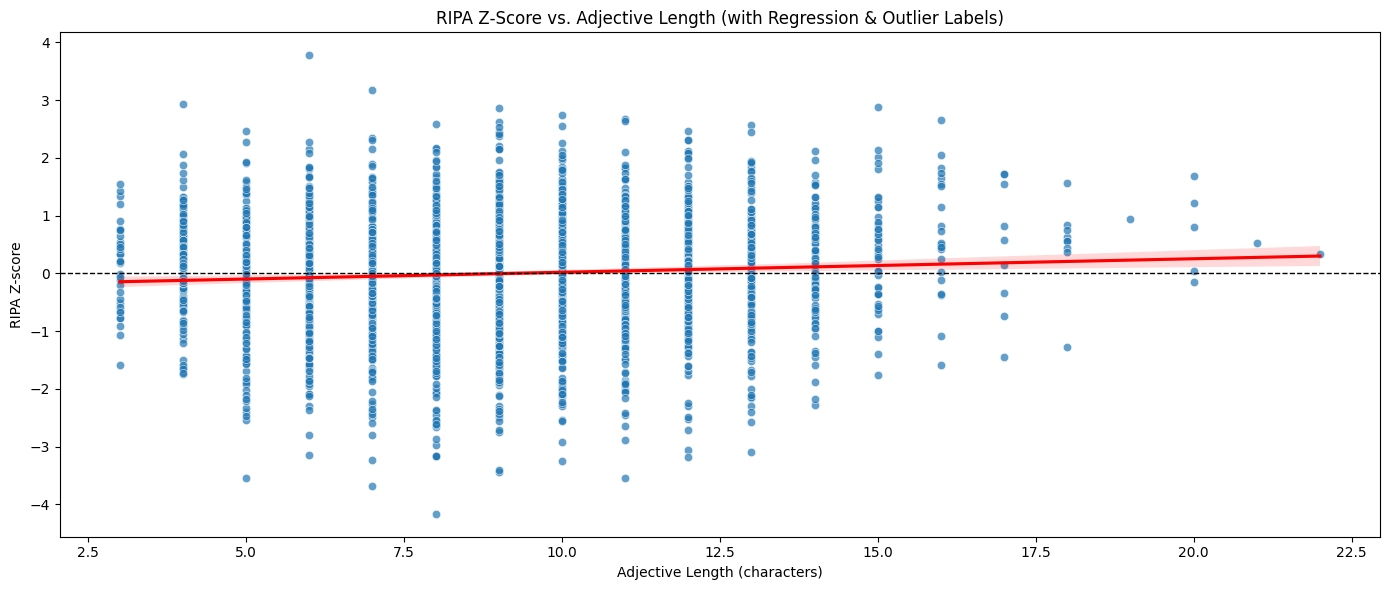

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Make sure 'adjective_length' column exists
df_combined['adjective_length'] = df_combined['word'].str.len()

fig, ax = plt.subplots(figsize=(14, 6))

# --- 1) Scatter Plot ---
sns.scatterplot(
    data=df_combined,
    x='adjective_length',
    y='ripa_z',
    alpha=0.7,
    ax=ax
)

# --- 2) Regression Line ---
sns.regplot(
    data=df_combined,
    x='adjective_length',
    y='ripa_z',
    scatter=False,   # we already have scatter from above
    line_kws={'color': 'red'},
    ax=ax
)

# --- 3) Reference line at y=0 ---
ax.axhline(0, color='black', linestyle='--', linewidth=1)

# --- 4) Outlier Annotation ---
# Filter rows where |ripa_z| > 4.5 (adjust threshold as desired)
threshold = 4.5
df_outliers = df_combined[df_combined['ripa_z'].abs() > threshold]

# Annotate each outlier
for i, row in df_outliers.iterrows():
    ax.annotate(
        text=row['word'],
        xy=(row['adjective_length'], row['ripa_z']),
        xytext=(5,5),  # offsets text a bit from the point
        textcoords='offset points',
        arrowprops=dict(arrowstyle='->', color='gray', lw=0.5),
        fontsize=9
    )

# --- 5) Axis Labels, Title, Layout ---
ax.set_xlabel('Adjective Length (characters)')
ax.set_ylabel('RIPA Z‐score')
ax.set_title('RIPA Z‐Score vs. Adjective Length (with Regression & Outlier Labels)')
plt.tight_layout()
plt.show()


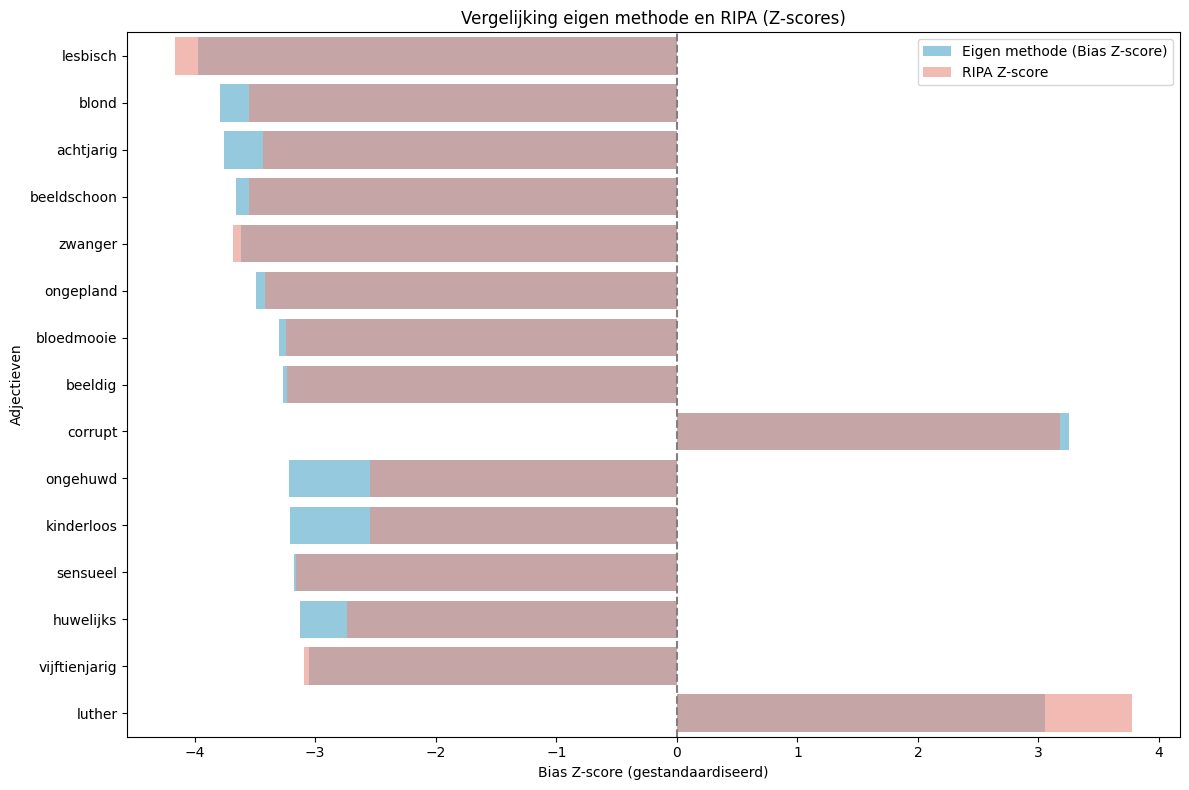

In [37]:
# Kies top 15 adjectieven met hoogste absolute bias_z (van je eigen methode)
top15_z = df_combined.reindex(df_combined['cosine_bias_z'].abs().sort_values(ascending=False).index).head(15)

plt.figure(figsize=(12, 8))

# Plot eigen methode
sns.barplot(x='cosine_bias_z', y='word', data=top15_z, color='skyblue', label='Eigen methode (Bias Z-score)')

# Overlay RIPA Z-scores
sns.barplot(x='ripa_z', y='word', data=top15_z, color='salmon', alpha=0.6, label='RIPA Z-score')

# Visualisatie details
plt.axvline(0, color='grey', linestyle='--')
plt.xlabel('Bias Z-score (gestandaardiseerd)')
plt.ylabel('Adjectieven')
plt.title('Vergelijking eigen methode en RIPA (Z-scores)')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import pandas as pd
import random

# ------------------------------------------------------------
# 1) Define your global sets of male/female words
# ------------------------------------------------------------
GLOBAL_MALE_WORDS = ["man", "kerel", "jongen", "vader", "zoon", 
                     "vent", "gast", "meneer", "opa", "oom"]

GLOBAL_FEMALE_WORDS = ["vrouw", "dame", "meisje", "moeder", "dochter", 
                       "tante", "oma", "mevrouw", "meid"]

# ------------------------------------------------------------
# 2) Create random subsets (e.g., 3) of these target words
# ------------------------------------------------------------
def create_random_subsets(words, n_subsets=3, subset_size=None, seed=42):
    """
    Create n_subsets random subsets from the original list 'words'.
    If subset_size is None, we use the full length (i.e. shuffle only).
    """
    random.seed(seed)
    subsets = []
    
    # By default, pick the same size as the original list, but randomly shuffle
    # This is effectively a "bootstrap without replacement" approach
    if subset_size is None:
        subset_size = len(words)
    
    for i in range(n_subsets):
        subset = random.sample(words, subset_size)
        subsets.append(subset)
    return subsets

# Example: create 3 subsets for male words and 3 for female words
male_subsets = create_random_subsets(GLOBAL_MALE_WORDS, n_subsets=3, subset_size=6)
female_subsets = create_random_subsets(GLOBAL_FEMALE_WORDS, n_subsets=3, subset_size=6)

# ------------------------------------------------------------
# 3) Function to compute bias for each adjective given a male/female subset
#    (Uses a simple "mean cosine difference" approach as an example)
# ------------------------------------------------------------
def compute_bias(adj, male_terms, female_terms, model):
    """
    Return male_mean - female_mean for the given adjective 'adj'.
    model should allow model[word] -> vector.
    """
    male_sims = []
    female_sims = []
    
    # Collect cosine similarities with male words
    if adj in model:
        for m in male_terms:
            if m in model:
                v_adj = model[adj]
                v_m = model[m]
                sim = np.dot(v_adj, v_m) / (np.linalg.norm(v_adj)*np.linalg.norm(v_m))
                male_sims.append(sim)
        # Collect with female words
        for f in female_terms:
            if f in model:
                v_f = model[f]
                sim = np.dot(v_adj, v_f) / (np.linalg.norm(v_adj)*np.linalg.norm(v_f))
                female_sims.append(sim)

    if len(male_sims) == 0 or len(female_sims) == 0:
        return None  # can't compute bias if missing vectors
    return np.mean(male_sims) - np.mean(female_sims)

# ------------------------------------------------------------
# 4) Master function to run sub-sampling + compute bias for all adjectives
# ------------------------------------------------------------
def run_subsampling_experiment(adjectives, model, n_subsets=3):
    """
    1. Creates random subsets of male/female words.
    2. Computes bias for each adjective under each subset.
    3. Aggregates results into a DataFrame.
    """
    # Step A: define or load your global male/female sets
    male_sets = create_random_subsets(GLOBAL_MALE_WORDS, n_subsets, 6)
    female_sets = create_random_subsets(GLOBAL_FEMALE_WORDS, n_subsets, 6)
    
    all_records = []
    
    # Step B: For each subset i, compute bias for each adjective
    for i in range(n_subsets):
        mset = male_sets[i]
        fset = female_sets[i]
        
        for adj in adjectives:
            val = compute_bias(adj, mset, fset, model)
            if val is not None:
                all_records.append({
                    'adjective': adj,
                    'subset_id': i,
                    'bias': val
                })
    
    # Convert to DataFrame
    df_all = pd.DataFrame(all_records)
    
    # Step C: Aggregate by taking mean of bias across the sub-samples
    df_agg = df_all.groupby('adjective', as_index=False).agg({
        'bias': 'mean'
    }).rename(columns={'bias': 'mean_bias'})
    
    return df_all, df_agg

# ------------------------------------------------------------
# 5) Example usage:
#    'filtered_adjectives' is your final cleaned list of 2753 adjectives
#    'model' is the embedding model you already loaded
# ------------------------------------------------------------
# Suppose we have that from your code:
# filtered_adjectives = [...]
# model = <your loaded KeyedVectors or WordEmbeddingModel>

# df_all_subsets: each row is (adjective, subset_id, bias)
# df_agg: one row per adjective, with the average bias across n_subsets
df_all_subsets_w2v, df_agg_w2v = run_subsampling_experiment(filtered_adjectives, w2v_model, n_subsets=5)
df_all_subsets_ft,  df_agg_ft  = run_subsampling_experiment(filtered_adjectives, fasttext_model, n_subsets=5)



In [46]:
df_compare = pd.merge(
    df_agg_w2v[['adjective','mean_bias']], 
    df_agg_ft[['adjective','mean_bias']], 
    on='adjective',
    suffixes=('_w2v','_ft')
)

print(df_compare.head())

from scipy.stats import pearsonr

corr, pval = pearsonr(df_compare['mean_bias_w2v'], df_compare['mean_bias_ft'])
print(f"Correlation (Word2Vec vs. FastText) = {corr:.3f} (p = {pval:.4g})")


      adjective  mean_bias_w2v  mean_bias_ft
0       aaibare       0.010563     -0.021541
1  aanbiddelijk      -0.038088     -0.065507
2    aandachtig      -0.001669      0.013896
3   aandoenlijk      -0.007461     -0.026432
4     aangenaam      -0.018719      0.007537
Correlation (Word2Vec vs. FastText) = 0.556 (p = 4.259e-222)


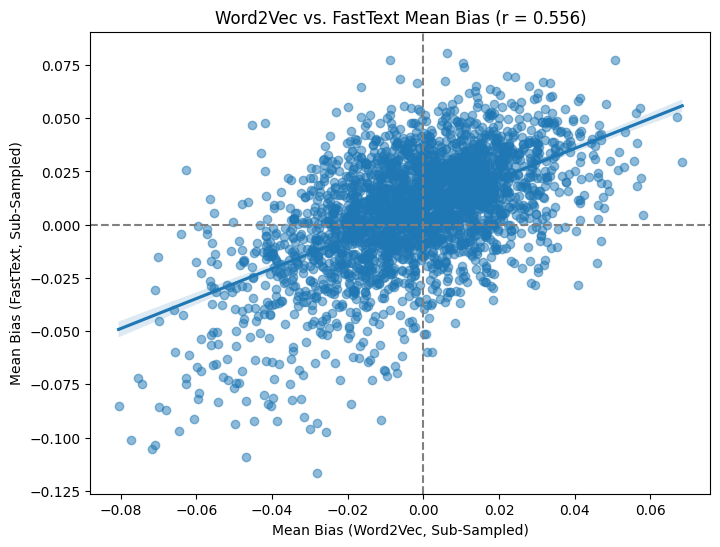

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,6))
sns.regplot(
    x='mean_bias_w2v', 
    y='mean_bias_ft', 
    data=df_compare, 
    scatter_kws={'alpha':0.5}
)
plt.title(f"Word2Vec vs. FastText Mean Bias (r = {corr:.3f})")
plt.xlabel("Mean Bias (Word2Vec, Sub-Sampled)")
plt.ylabel("Mean Bias (FastText, Sub-Sampled)")
plt.axvline(0, color='grey', linestyle='--')
plt.axhline(0, color='grey', linestyle='--')
plt.show()


In [48]:
df_agg_w2v['abs_mean_bias'] = df_agg_w2v['mean_bias'].abs()
df_agg_w2v_sorted = df_agg_w2v.sort_values('abs_mean_bias', ascending=False)
top_15_w2v = df_agg_w2v_sorted.head(15)

print("\n=== Top 15 Most Biased (Word2Vec) ===")
print(top_15_w2v[['adjective', 'mean_bias', 'abs_mean_bias']])



=== Top 15 Most Biased (Word2Vec) ===
         adjective  mean_bias  abs_mean_bias
1239      lesbisch  -0.080530       0.080530
167    beeldschoon  -0.077311       0.077311
166        beeldig  -0.075289       0.075289
273          blond  -0.074230       0.074230
2124      sensueel  -0.071631       0.071631
2387        tuttig  -0.071017       0.071017
2245      stijlvol  -0.071014       0.071014
37       achtjarig  -0.070195       0.070195
1891  platinablond  -0.069975       0.069975
271     bloedmooie  -0.069786       0.069786
1300        luther   0.068425       0.068425
226       bevallig  -0.068117       0.068117
371        corrupt   0.067110       0.067110
1126       kleurig  -0.065869       0.065869
2056         rozig  -0.065743       0.065743


In [49]:
df_agg_ft['abs_mean_bias'] = df_agg_ft['mean_bias'].abs()
df_agg_ft_sorted = df_agg_ft.sort_values('abs_mean_bias', ascending=False)
top_15_ft = df_agg_ft_sorted.head(15)

print("\n=== Top 15 Most Biased (FastText) ===")
print(top_15_ft[['adjective', 'mean_bias', 'abs_mean_bias']])



=== Top 15 Most Biased (FastText) ===
          adjective  mean_bias  abs_mean_bias
2166        snoezig  -0.116509       0.116509
1385         mollig  -0.109089       0.109089
2116       sensueel  -0.105422       0.105422
2375         tuttig  -0.103591       0.103591
165     beeldschoon  -0.101366       0.101366
754        genitaal  -0.097418       0.097418
2728        zwanger  -0.096925       0.096925
638        feminien  -0.095959       0.095959
2672          zedig  -0.093733       0.093733
139       aziatisch  -0.093302       0.093302
1108         kittig  -0.092369       0.092369
1260     lieftallig  -0.092060       0.092060
2290  superschattig  -0.091711       0.091711
832      goudblonde  -0.091332       0.091332
2146      sletterig  -0.090496       0.090496


In [50]:
set_w2v = set(top_15_w2v['adjective'])
set_ft = set(top_15_ft['adjective'])

overlap = set_w2v.intersection(set_ft)
print(f"\nOverlap in Top‐15: {len(overlap)} words")
print(overlap)



Overlap in Top‐15: 3 words
{'sensueel', 'beeldschoon', 'tuttig'}



Average standard deviation across all adjectives:
   Word2Vec : 0.0126
   FastText : 0.0124

Median standard deviation across all adjectives:
   Word2Vec : 0.0122
   FastText : 0.0118


/var/folders/v_/ypb5b1nx079dj_hcjyz0t47c0000gn/T/ipykernel_95624/2001226075.py:67: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df_compare_stability['std_bias_w2v'], label='Word2Vec STD(Bias)', shade=True)
/var/folders/v_/ypb5b1nx079dj_hcjyz0t47c0000gn/T/ipykernel_95624/2001226075.py:68: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df_compare_stability['std_bias_ft'], label='FastText STD(Bias)', shade=True)


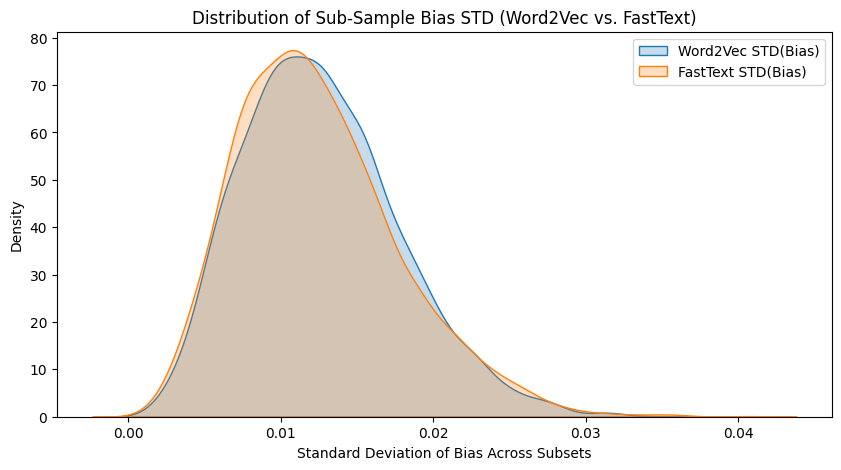


=== Adjectives that are MUCH more stable in FastText (negative diff_std) ===
         adjective  std_bias_w2v  mean_bias_w2v  std_bias_ft  mean_bias_ft  \
1791   opzettelijk      0.024728       0.018741     0.002071      0.016180   
510       dusdanig      0.024596       0.007871     0.004465      0.018300   
2543  vraatzuchtig      0.027069       0.015801     0.009563     -0.017615   
1154    kortademig      0.020032      -0.012384     0.002950      0.001601   
2330     thuisloos      0.023277       0.004926     0.006803     -0.015111   
2214     stateloos      0.024696       0.013736     0.008593      0.032792   
159     bedlegerig      0.022924      -0.016767     0.007537     -0.057157   
2297     surinaams      0.018935      -0.041070     0.003657     -0.011721   
1316    marokkaans      0.028352      -0.047585     0.013312     -0.017231   
1200     lafhartig      0.022519       0.026121     0.007483      0.041371   

      diff_std  
1791  0.022657  
510   0.020132  
2543  0.0175

In [55]:
import pandas as pd
import numpy as np

# Assume you already ran:
# df_all_subsets_w2v, df_agg_w2v = run_subsampling_experiment(filtered_adjectives, w2v_model, n_subsets=5)
# df_all_subsets_ft,  df_agg_ft  = run_subsampling_experiment(filtered_adjectives, fasttext_model, n_subsets=5)
# (You can set n_subsets=5 or 10 or more for an even more robust measure.)

# -------------------------------------------------
# 1) Compute the std. dev. of bias across subsets for each adjective
# -------------------------------------------------

# For Word2Vec
df_std_w2v = (
    df_all_subsets_w2v
    .groupby('adjective', as_index=False)
    .agg(std_bias=('bias','std'), mean_bias=('bias','mean'))
)

# For FastText
df_std_ft = (
    df_all_subsets_ft
    .groupby('adjective', as_index=False)
    .agg(std_bias=('bias','std'), mean_bias=('bias','mean'))
)

# -------------------------------------------------
# 2) Merge so we can compare side-by-side
# -------------------------------------------------
df_compare_stability = pd.merge(
    df_std_w2v[['adjective','std_bias','mean_bias']],
    df_std_ft[['adjective','std_bias','mean_bias']],
    on='adjective',
    how='inner',
    suffixes=('_w2v','_ft')
)

# Now we have columns: ['adjective','std_bias_w2v','mean_bias_w2v','std_bias_ft','mean_bias_ft']

# -------------------------------------------------
# 3) Compare the overall distributions of std. dev.
# -------------------------------------------------
mean_std_w2v = df_compare_stability['std_bias_w2v'].mean()
mean_std_ft  = df_compare_stability['std_bias_ft'].mean()

print(f"\nAverage standard deviation across all adjectives:")
print(f"   Word2Vec : {mean_std_w2v:.4f}")
print(f"   FastText : {mean_std_ft:.4f}")

# Maybe also compute median:
median_std_w2v = df_compare_stability['std_bias_w2v'].median()
median_std_ft  = df_compare_stability['std_bias_ft'].median()
print(f"\nMedian standard deviation across all adjectives:")
print(f"   Word2Vec : {median_std_w2v:.4f}")
print(f"   FastText : {median_std_ft:.4f}")

# A lower average/median std. dev. suggests that the model is more stable
# (less sensitive to changing the male/female target words).

# -------------------------------------------------
# 4) (Optional) Visualize the difference in distributions
# -------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,5))
sns.kdeplot(df_compare_stability['std_bias_w2v'], label='Word2Vec STD(Bias)', shade=True)
sns.kdeplot(df_compare_stability['std_bias_ft'], label='FastText STD(Bias)', shade=True)
plt.xlabel("Standard Deviation of Bias Across Subsets")
plt.ylabel("Density")
plt.title("Distribution of Sub-Sample Bias STD (Word2Vec vs. FastText)")
plt.legend()
plt.show()

# -------------------------------------------------
# 5) Explore which words have the biggest difference in stability
# -------------------------------------------------

df_compare_stability['diff_std'] = df_compare_stability['std_bias_w2v'] - df_compare_stability['std_bias_ft']
df_compare_stability = df_compare_stability.sort_values('diff_std', ascending=False)

print("\n=== Adjectives that are MUCH more stable in FastText (negative diff_std) ===")
print(df_compare_stability.head(10))

print("\n=== Adjectives that are MUCH more stable in Word2Vec (positive diff_std) ===")
print(df_compare_stability.tail(10))


In [56]:
import pandas as pd
import numpy as np

# Suppose we already did:
# df_all_subsets = run_subsampling_experiment(...)[0] 
# (the first returned DataFrame: each row is (adjective, subset_id, bias))

def sign_consistency(df_all_subsets):
    """
    For each adjective, calculate:
    - count_positive: # of sub-samples with bias > 0
    - count_negative: # of sub-samples with bias < 0
    - n_subsets: total # of sub-samples for that adjective
    - sign_consistency: max fraction of positive or negative across sub-samples
       (e.g. 1.0 means always same sign, 0.5 means half the time +, half -)
    - final_sign: the "dominant" sign (1=male-biased if more +, -1=female-biased if more -)
    """
    # Group by adjective
    grouped = df_all_subsets.groupby('adjective')
    
    records = []
    for adj, group in grouped:
        n = len(group)
        c_pos = sum(group['bias'] > 0)
        c_neg = sum(group['bias'] < 0)
        
        frac_pos = c_pos / n
        frac_neg = c_neg / n
        
        # sign_consistency is highest fraction
        sc = max(frac_pos, frac_neg)
        
        # final sign = +1 if mostly positive, -1 if mostly negative
        final_sign = 1 if frac_pos >= frac_neg else -1
        
        records.append({
            'adjective': adj,
            'n_subsets': n,
            'count_positive': c_pos,
            'count_negative': c_neg,
            'sign_consistency': sc,
            'final_sign': final_sign
        })
    
    return pd.DataFrame(records)

df_sign_info = sign_consistency(df_all_subsets_w2v)
print(df_sign_info.sort_values('sign_consistency', ascending=False).head(10))


         adjective  n_subsets  count_positive  count_negative  \
2752         zwoel          5               0               5   
998     impopulair          5               5               0   
1025      inherent          5               5               0   
2098       schraal          5               0               5   
1023       inhalig          5               5               0   
1021   ingeburgerd          5               5               0   
2102  schriftelijk          5               0               5   
2104        schuin          5               0               5   
2106   schuldeloos          5               5               0   
1015   indonesisch          5               0               5   

      sign_consistency  final_sign  
2752               1.0          -1  
998                1.0           1  
1025               1.0           1  
2098               1.0          -1  
1023               1.0           1  
1021               1.0           1  
2102               1.0   

In [57]:
def compute_per_subset_zscores(df_all_subsets):
    """
    df_all_subsets: columns = ['adjective','subset_id','bias']
    
    For each subset_id:
      1) compute mean+std of bias
      2) convert each row's bias to z = (bias - mean) / std
    Returns a new DataFrame with column 'zscore'.
    """
    df = df_all_subsets.copy()
    zscores = []
    
    for subset_id, group in df.groupby('subset_id'):
        mu = group['bias'].mean()
        sd = group['bias'].std()
        # compute z for each row in this subset
        for idx, row in group.iterrows():
            z = (row['bias'] - mu)/sd if sd != 0 else 0.0
            zscores.append((idx, z))
    
    # incorporate z-scores into df
    z_map = dict(zscores)
    df['zscore'] = df.index.map(z_map)
    return df

df_all_subsets_z = compute_per_subset_zscores(df_all_subsets_w2v)

# Now average z-scores by adjective
df_z_agg = df_all_subsets_z.groupby('adjective', as_index=False).agg({
    'zscore': 'mean'
}).rename(columns={'zscore': 'mean_zscore'})

# If you want, also keep track of standard deviation of z-scores:
df_z_agg['std_zscore'] = df_all_subsets_z.groupby('adjective')['zscore'].std().values


In [58]:
def borda_count_ranking(df_all_subsets):
    """
    df_all_subsets: columns = ['adjective','subset_id','bias']
    Steps:
      1) For each subset_id, rank adjectives by descending bias
      2) Assign points: if there are M adjectives, top rank = M points, 
         second = M-1, etc.
      3) Sum points over all subsets -> final Borda score
      4) Return DataFrame: [adjective, borda_score]
    """
    df = df_all_subsets.copy()
    
    # We'll find all unique adjectives in the entire data
    unique_adjs = df['adjective'].unique()
    n_adjs = len(unique_adjs)
    
    # We'll store partial results as (adjective, subset_id, rank, points)
    records = []
    
    for subset_id, group in df.groupby('subset_id'):
        # Sort by bias descending, so the highest bias gets rank=1
        group_sorted = group.sort_values('bias', ascending=False).reset_index(drop=True)
        
        # If there are K adjectives in this subset, top rank gets K points, etc.
        K = len(group_sorted)
        
        for i, row in group_sorted.iterrows():
            rank = i+1  # 1-based rank
            # Borda points: top rank => K, second => K-1, ...
            # you can define this differently if you prefer
            points = K - (rank - 1)
            records.append({
                'adjective': row['adjective'],
                'subset_id': subset_id,
                'rank': rank,
                'borda_points': points
            })
    
    df_borda = pd.DataFrame(records)
    
    # Summation of points across all subsets
    df_borda_agg = df_borda.groupby('adjective', as_index=False)['borda_points'].sum()
    df_borda_agg = df_borda_agg.rename(columns={'borda_points':'borda_score'})
    
    # Sort by Borda score (descending)
    df_borda_agg = df_borda_agg.sort_values('borda_score', ascending=False)
    
    return df_borda, df_borda_agg

# Example usage:
df_borda, df_borda_agg = borda_count_ranking(df_all_subsets_w2v)

print("\n=== Borda Ranking (Top 15) ===")
print(df_borda_agg.head(15))



=== Borda Ranking (Top 15) ===
            adjective  borda_score
371           corrupt        13746
1300           luther        13744
998        impopulair        13711
1662  onoverwinnelijk        13709
1007      incompetent        13695
816         goddeloos        13689
1370         misdadig        13686
2069       sadistisch        13659
996          immoreel        13646
757           geniaal        13644
39             actief        13631
2545    voortvluchtig        13601
2229        steenrijk        13591
2085        schatrijk        13590
1065     islamistisch        13589


In [61]:
# 1) Sign info
df_sign_info = sign_consistency(df_all_subsets_w2v)

# 2) Z-scores (subset-level)
df_all_subsets_z = compute_per_subset_zscores(df_all_subsets_w2v)
df_z_agg = df_all_subsets_z.groupby('adjective').agg({
    'zscore': ['mean','std']
}).reset_index()
df_z_agg.columns = ['adjective','mean_zscore','std_zscore']

# 3) Borda ranking
df_borda, df_borda_agg = borda_count_ranking(df_all_subsets_w2v)

# 4) Merge them all
df_merged = pd.merge(df_sign_info, df_z_agg, on='adjective', how='left')
df_merged = pd.merge(df_merged, df_borda_agg, on='adjective', how='left')

# For convenience, define a final ordering
# For example: 
#  - We want stable sign => sign_consistency high
#  - We want large magnitude => large |mean_zscore|
#  - We want top Borda => large borda_score
# Let's do a simple rank-based combination
df_merged['rank_sign_consistency'] = df_merged['sign_consistency'].rank(ascending=False)
df_merged['rank_abs_zscore'] = df_merged['mean_zscore'].abs().rank(ascending=False)
df_merged['rank_borda'] = df_merged['borda_score'].rank(ascending=False)

# Sort by 'combined_rank' ascending => "best" overall
df_merged = df_merged.sort_values('rank_borda').reset_index(drop=True)

print("\n=== Final Combined Ranking (Top 15) ===")
print(df_merged.head(15)[['adjective','sign_consistency','mean_zscore','borda_score']])



=== Final Combined Ranking (Top 15) ===
          adjective  sign_consistency  mean_zscore  borda_score
0           corrupt               1.0     3.039518        13746
1            luther               1.0     3.071305        13744
2        impopulair               1.0     2.621311        13711
3   onoverwinnelijk               1.0     2.568828        13709
4       incompetent               1.0     2.550053        13695
5         goddeloos               1.0     2.593958        13689
6          misdadig               1.0     2.545321        13686
7        sadistisch               1.0     2.364536        13659
8          immoreel               1.0     2.407779        13646
9           geniaal               1.0     2.319389        13644
10           actief               1.0     2.469779        13631
11    voortvluchtig               1.0     2.241279        13601
12        steenrijk               1.0     2.197308        13591
13        schatrijk               1.0     2.152651        13590

In [62]:
print("\n=== Final Combined Ranking (Top 15) ===")
print(df_merged.tail(15)[['adjective','sign_consistency','mean_zscore','borda_score',]])


=== Final Combined Ranking (Top 15) ===
         adjective  sign_consistency  mean_zscore  borda_score
2738    glamoureus               1.0    -2.629944          165
2739   donkerharig               1.0    -2.652100          139
2740     achtjarig               1.0    -3.012120          137
2741         rozig               1.0    -2.760618          120
2742       kleurig               1.0    -2.781730          117
2743      bevallig               1.0    -2.877664           97
2744         blond               1.0    -3.140110           91
2745      stijlvol               1.0    -3.004738           87
2746    bloedmooie               1.0    -2.983463           85
2747        tuttig               1.0    -2.994093           74
2748  platinablond               1.0    -2.967569           73
2749   beeldschoon               1.0    -3.315547           62
2750      sensueel               1.0    -3.051316           58
2751       beeldig               1.0    -3.196810           46
2752      lesb